<a href="https://colab.research.google.com/github/parrisatwork/Prediction-of-Product-Sales/blob/main/Explaining_Models_with_Shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Revisited - Part 2: Explanations

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
## Customization Options
pd.set_option("display.max_columns",100)
plt.style.use(['fivethirtyeight','seaborn-talk'])
mpl.rcParams['figure.facecolor']='white'
## additional required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn import metrics
## fixing random for lesson generation
SEED = 321
np.random.seed(SEED)

<ipython-input-1-3ca4491f19d2>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['fivethirtyeight','seaborn-talk'])


## Load Data

In [2]:
import joblib
loaded_joblib = joblib.load('/content/drive/MyDrive/Data/best_models.joblib')
loaded_joblib.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator OneHotEncoder from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info 

dict_keys(['X_train_df', 'X_train_rf', 'y_train', 'X_test_df', 'X_test_rf', 'y_test', 'preprocessor', 'preprocessor_rf', 'LinearRegression', 'RandomForest'])

In [3]:
X_train = loaded_joblib['X_train_rf']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test_rf']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor_rf']
rf_reg = loaded_joblib['RandomForest']

In [4]:
X_train

Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
8269                       1.0                     1.0               0.0   
7604                       0.0                     0.0               0.0   
2762                       0.0                     0.0               0.0   
6464                       0.0                     0.0               0.0   
4707                       1.0                     0.0               0.0   
...                        ...                     ...               ...   
3482                       0.0                     0.0               0.0   
8360                       0.0                     0.0               0.0   
5929                       0.0                     0.0               0.0   
4220                       1.0                     0.0               1.0   
6682                       0.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
8269                  0.0               0.0              0.0   
7604                  0.0               0.0              0.0   
2762                  0.0               0.0              0.0   
6464                  0.0               0.0              0.0   
4707                  0.0               0.0              0.0   
...                   ...               ...              ...   
3482                  0.0               0.0              0.0   
8360                  0.0               0.0              0.0   
5929                  0.0               0.0              0.0   
4220                  0.0               0.0              0.0   
6682                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
8269                     0.0                              0.0   
7604                     0.0                              0.0   
2762                     0.0                              0.0   
6464                     0.0                              0.0   
4707                     0.0                              1.0   
...                      ...                              ...   
3482                     0.0                              1.0   
8360                     0.0                              0.0   
5929                     0.0                              0.0   
4220                     0.0                              0.0   
6682                     0.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
8269                    0.0                           0.0   
7604                    0.0                           0.0   
2762                    0.0                           0.0   
6464                    0.0                           0.0   
4707                    0.0                           0.0   
...                     ...                           ...   
3482                    0.0                           0.0   
8360                    0.0                           0.0   
5929                    0.0                           0.0   
4220                    0.0                           0.0   
6682                    0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Others  \
8269                  0.0             0.0               0.0   
7604                  0.0             0.0               0.0   
2762                  1.0             0.0               0.0   
6464                  1.0             0.0               0.0   
4707                  0.0             0.0               0.0   
...                   ...             ...               ...   
3482                  0.0             0.0               0.0   
8360                  0.0             0.0               0.0   
5929                  1.0             0.0               0.0   
4220                  0.0             0.0               0.0   
6682                  0.0             0.0               0.0   

      Item_Type_Seafood  Item_Type_Snack Foods  Item_

In [5]:
print(f"Training R^2: {rf_reg.score(X_train,y_train):.3f}")
print(f"Test R^2: {rf_reg.score(X_test, y_test):.3f}")

Training R^2: 0.937
Test R^2: 0.561


## Apply SHAP

In [6]:
# Taken from google
!pip install --upgrade --quiet witwidget shap

In [7]:
import shap
shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### X_shap, y_shap Variables

In [8]:
X_shap = shap.sample(X_train, nsamples=400, random_state=321)
X_shap

Item_Fat_Content_Regular  Item_Type_Baking Goods  Item_Type_Breads  \
7510                       1.0                     0.0               0.0   
3625                       0.0                     0.0               0.0   
43                         0.0                     0.0               0.0   
7364                       0.0                     0.0               0.0   
5511                       0.0                     0.0               0.0   
...                        ...                     ...               ...   
6175                       0.0                     0.0               0.0   
8017                       0.0                     0.0               0.0   
3462                       0.0                     0.0               0.0   
6940                       0.0                     0.0               0.0   
4721                       0.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
7510                  0.0               0.0              0.0   
3625                  0.0               0.0              0.0   
43                    0.0               1.0              0.0   
7364                  0.0               1.0              0.0   
5511                  0.0               0.0              0.0   
...                   ...               ...              ...   
6175                  0.0               1.0              0.0   
8017                  0.0               0.0              0.0   
3462                  0.0               0.0              0.0   
6940                  0.0               0.0              0.0   
4721                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
7510                     0.0                              0.0   
3625                     0.0                              0.0   
43                       0.0                              0.0   
7364                     0.0                              0.0   
5511                     0.0                              1.0   
...                      ...                              ...   
6175                     0.0                              0.0   
8017                     0.0                              0.0   
3462                     0.0                              0.0   
6940                     0.0                              0.0   
4721                     1.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
7510                    0.0                           0.0   
3625                    0.0                           0.0   
43                      0.0                           0.0   
7364                    0.0                           0.0   
5511                    0.0                           0.0   
...                     ...                           ...   
6175                    0.0                           0.0   
8017                    0.0                           0.0   
3462                    0.0                           0.0   
6940                    0.0                           1.0   
4721                    0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Others  \
7510                  0.0             0.0               0.0   
3625                  0.0             0.0               0.0   
43                    0.0             0.0               0.0   
7364                  0.0             0.0               0.0   
5511                  0.0             0.0               0.0   
...                   ...             ...               ...   
6175                  0.0             0.0               0.0   
8017                  0.0             1.0               0.0   
3462                  0.0             0.0               0.0   
6940                  0.0             0.0               0.0   
4721                  0.0             0.0               0.0   

      Item_Type_Seafood  Item_Type_Snack Foods  Item_

In [9]:
y_shap = y_train.loc[X_shap.index]
y_shap

7510    3056.0220
3625    1323.6104
43      6768.5228
7364    3894.9300
5511    4656.6052
          ...    
6175    3089.9778
8017     765.6700
3462    4492.8184
6940    2441.4886
4721    1145.1760
Name: Item_Outlet_Sales, Length: 400, dtype: float64

## Model Explainer

In [10]:
explainer = shap.Explainer(rf_reg)
explainer

## SHAP Values

In [11]:
shap_values = explainer(X_shap,y_shap)
shap_values.shape

(400, 42)

In [12]:
X_shap.shape

(400, 42)

In [13]:
shap_values[0]

.values =
array([ 2.42001365e+01,  2.99035440e-02, -1.87413225e+00, -2.48524770e+00,
        2.04585596e+00,  1.97230686e+00,  4.19013323e+00,  4.70123457e+00,
        2.15311521e+00,  1.03745704e+00, -7.12506898e+00, -1.76474983e+00,
       -2.25120696e-01, -7.56209013e-01,  9.98974603e+01,  3.80924154e+00,
       -7.91204765e+00, -7.85409336e-02, -1.21521966e+01, -2.79922398e+01,
       -2.50221030e+01,  2.88007011e-02, -9.26642196e+01, -1.01490040e+00,
        7.12708397e+00,  7.42375551e+00, -1.26946408e+00, -6.11884900e+00,
       -1.13366728e+01, -6.98877183e+00,  1.24095470e+01,  6.82508850e+00,
       -2.37917287e+01, -1.06439223e+00,  3.02335260e+02, -7.97953726e+01,
       -4.34470472e+01, -8.87765707e+01,  9.98965884e+01, -2.73908579e+01,
        9.26128941e+02, -1.24314829e+02])

.base_values =
array([2154.71233664])

.data =
array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
      

## Summary Bar Plot

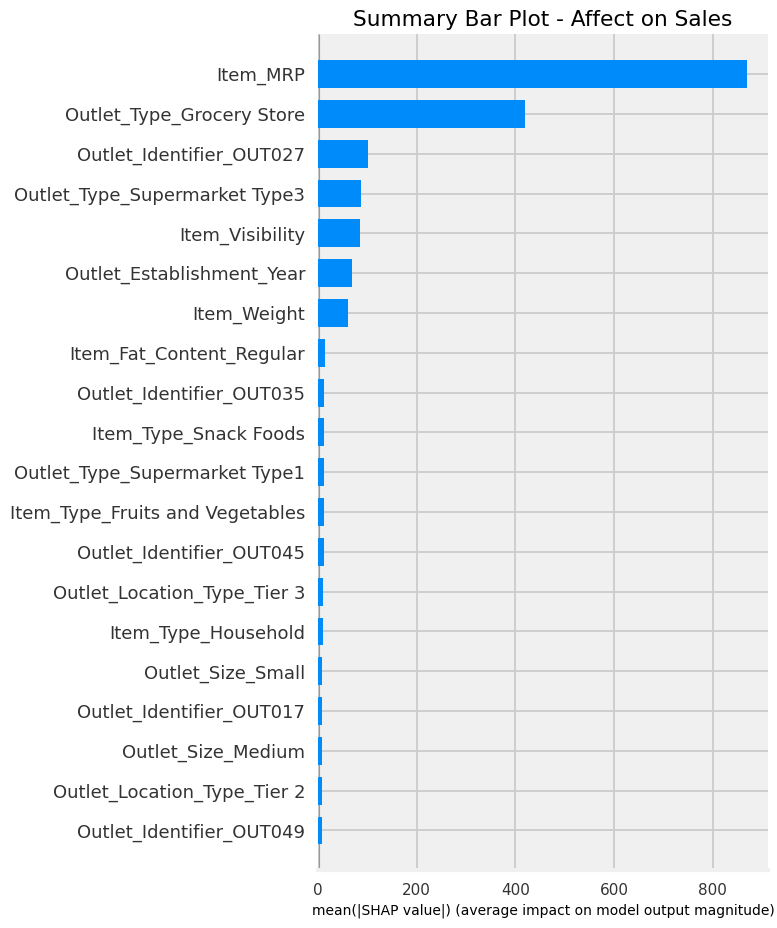

In [14]:
fig, ax = plt.subplots()

shap.summary_plot(shap_values,X_shap, show=False, plot_type='bar')

ax.set_title('Summary Bar Plot - Affect on Sales')
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontsize=10)
plt.tight_layout();

fig.savefig('/content/drive/MyDrive/Data/summary_plot_bar_rf_reg.png', dpi=70, bbox_inches='tight')

### Summary Bar Plot Comparison

Default and Permutation Importances have the same top 5 features

SHAP Plot Summary differs in that:

'Item_Visibility' is ranked lower (5th instead of 3rd)
'Outlet_Type_Supermarket Type 3' takes the place of 'Item_Weight' (ranked 4th)
'Outlet_Identifier_OUT027' is ranked higher (3rd instead of 5th)

## Summary Dot Plot

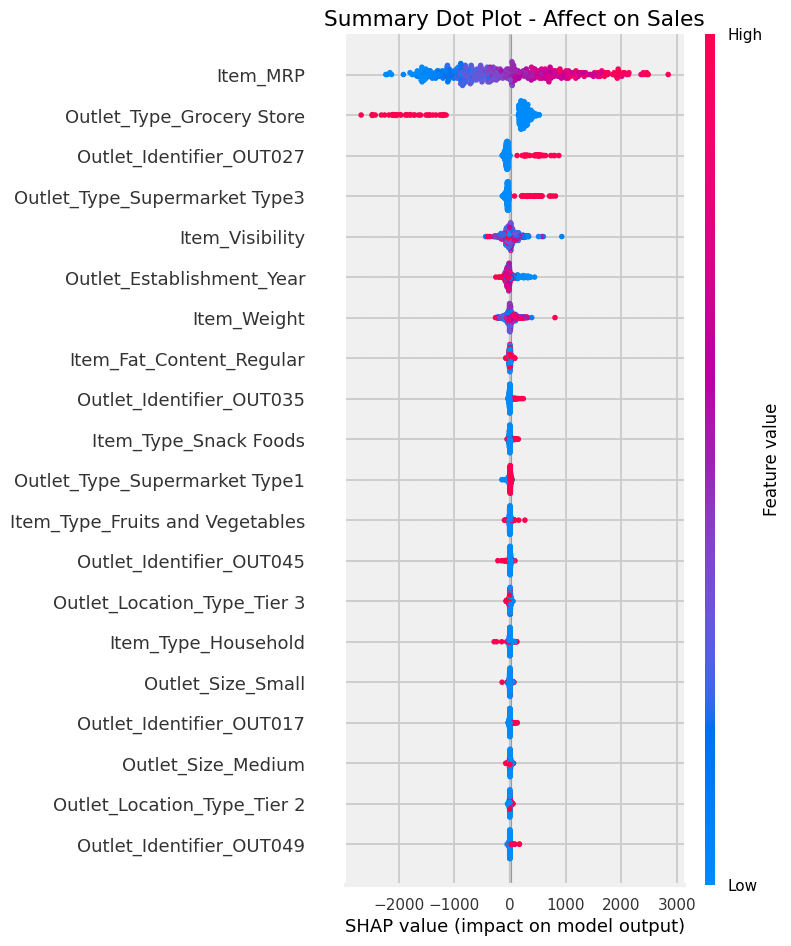

In [16]:
fig, ax = plt.subplots()

shap.summary_plot(shap_values,X_shap, show=False)

ax.set_title('Summary Dot Plot - Affect on Sales');

fig.savefig('/content/drive/MyDrive/Data//summary_plot_dot_rf_reg.png', dpi=70, bbox_inches='tight')

### Summary Dot Plot Interpretation

Interpret Top 3 Features

'Item_MRP':

As the value of the item's MRP increases (gets redder), the target value ('Item_Outlet_Sales') increases as well (moves right)
'Outlet_Type_Grocery_Store' (true/false):

Being a Grocery Store (red/true) will decrease (move left) the target value ('Item_Outlet_Sales')
Not being a Grocery Store (blue/false) will increase (move right) the target value ('Item_Outlet_Sales')
'Outlet_Identifier_OUT027' (true/false):

Being Outlet OUT027 (red/true) will increase (move right) the target value ('Item_Outlet_Sales')
Not being a Outlet OUT027 (blue/false) will only marginally affect (keep center at 0 or slightly move left) the target value ('Item_Outlet_Sales')

# Local Explanations

### Instantiating Local X_shap/y_shap

In [17]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)

### SHAP Values Local

In [18]:
# Getting the shap values wth the local X_shap
shap_values_local = explainer(X_shap_local,y_shap_local)
shap_values_local.shape

(400, 42)

### Predictions

In [19]:
y_pred = rf_reg.predict(X_shap_local)
y_pred = pd.Series(y_pred, index=X_shap_local.index, name='Predicted')
y_pred

0      3065.562914
1      2283.128070
2      5911.152166
3      3426.486436
4      4153.320322
          ...     
395    2962.284018
396     929.203796
397    3636.293332
398    2320.299684
399    1294.867814
Name: Predicted, Length: 400, dtype: float64

### Selecting Examples - Based on Max/Min Sales

## Get y_shap_local Indexes

In [20]:
y_shap_local.agg(['min', 'max'])

min       37.9506
max    10256.6490
Name: Item_Outlet_Sales, dtype: float64

In [21]:
high_sales = y_shap_local == y_shap_local.max()
y_shap_local[high_sales]

58    10256.649
Name: Item_Outlet_Sales, dtype: float64

In [22]:
row_high = y_shap_local[high_sales].idxmax()
row_high

58

In [23]:
low_sales = y_shap_local == y_shap_local.min()
y_shap_local[low_sales]

196    37.9506
Name: Item_Outlet_Sales, dtype: float64

In [24]:
row_low = y_shap_local[low_sales].idxmax()
row_low

196

## Get X_shap_local Filters

In [25]:
filt_high_sales = X_shap_local.iloc[385]
filt_high_sales.tail()

Outlet_Type_Supermarket Type3       0.000000
Item_Weight                         7.550000
Item_Visibility                     0.031071
Item_MRP                          122.407200
Outlet_Establishment_Year        2009.000000
Name: 385, dtype: float64

In [26]:
filt_low_sales = X_shap_local.iloc[178]
filt_low_sales.tail()

Outlet_Type_Supermarket Type3       0.0000
Item_Weight                         7.6800
Item_Visibility                     0.0709
Item_MRP                          192.6162
Outlet_Establishment_Year        1997.0000
Name: 178, dtype: float64

## Individual Force Plot

### High Sales

In [27]:
y_shap_local[high_sales].idxmax()

58

In [28]:
print(f"Example of a Store with High Sales:")
print(f"True Class: Sales = {y_shap_local.iloc[385]}")
print(f"Predicted Class: Sales = {y_pred.iloc[385]}")

Example of a Store with High Sales:
True Class: Sales = 857.5504
Predicted Class: Sales = 1264.1677759999975


In [29]:
# row_high = 385
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[row_high].values,
               features=X_shap.iloc[row_high])

## Low Sales

In [30]:
print(f"Example of a Store with Low Sales:")
print(f"True Class: Sales = {y_shap_local.iloc[178]}")
print(f"Predicted Class: Sales = {y_pred.iloc[178]}")

Example of a Store with Low Sales:
True Class: Sales = 5580.0698
Predicted Class: Sales = 4645.426417999999


In [31]:
# row_low = 178
## Individual forceplot
shap.force_plot(explainer.expected_value,
                shap_values= shap_values[row_low].values,
               features=X_shap.iloc[row_low])

## Lime Tabular Explanation

In [38]:
# From Google
!pip install lime

In [39]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,
    feature_names=X_shap_local.columns,
    mode='regression'
)
lime_explainer

### High Sales

In [40]:
exp_high = lime_explainer.explain_instance(X_shap_local.iloc[row_high],
                                      rf_reg.predict)
exp_high.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [41]:
exp_high.save_to_file('/content/drive/MyDrive/Data/lime_high_sales.html')


In [55]:
# From Google
from IPython.display import HTML

In [56]:
high_sales_html = HTML('<iframe src="/content/drive/MyDrive/Data/lime_high_sales.html" width="710" height="550"></iframe>')
high_sales_html

Predicted Value is 6693.23 where True Value is 8323.8316

Interpreting our Features with the 'negative' and 'positive' bar chart

Positive (higher sales) include:
'Outlet_Type_Grocery Store' (not a Grocery Store)
'Item_MRP' (greater than 180.25 at 219.35)
Negative (lower sales) include:
'Outlet_Identifier_OUT027' (not this Outlet)
'Outlet_Type_Supermarket Type3' (not this Outlet Type)
Even though the Feature Names are cutoff, they can be seen in the bottom graph (Feature/Value)

### Low Sales

In [47]:
exp_low = lime_explainer.explain_instance(X_shap_local.iloc[row_low],
                                      rf_reg.predict)
exp_low.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


In [57]:
exp_low.save_to_file('/content/drive/MyDrive/Data/lime_low_sales.html')

In [58]:
low_sales_html = HTML('<iframe src="/content/drive/MyDrive/Data/lime_low_sales.html" width="710" height="550"></iframe>')
low_sales_html


Predicted Value is 63.42 where True Value is 36.62

Interpreting our Features with the 'negative' and 'positive' bar chart

Negative (lower sales) include:

'Outlet_Type_Grocery Store' (is a Grocery Store)
'Item_MRP' (less than or equal to 90.72 at 35.22)
'Outlet_Identifier_OUT027' (is not this Outlet)
'Outlet_Type_Supermarket Type3' (is not this Outlet Type)
Positive (higher sales) include:

'Item_Type_Seafood' (is not this Item Type)
'Outlet_Identifier_OUT045' (is not this Outlet)
Even though the Feature Names are cutoff, they can be seen in the bottom graph (Feature/Value)